# Document Alignment

## Description
In this project we implement a system for aligning a scanned document to a reference template using computer vision techniques. The alignment is achieved through feature matching, homography estimation, and image warping. The system outputs intermediary steps, including keypoints, matched features, and the final aligned image.

## Requirements
- **Libraries**: OpenCV, NumPy, Matplotlib, OS
- **File Structure**:
  - Input images stored in `images/`
  - Output images stored in `outputImages/`

## Outputs
### Expected Outputs
1. **Images**:
   - Original and scanned images.
   - Keypoints detected in both images.
   - Matched keypoints visualization.
   - Final aligned image.

### Sample Outputs
The processed images, including visualizations of the detected keypoints, matched keypoints, and the aligned image, are saved in the `outputImages/` directory.

## Algorithm Details

1. **Load Images**
    - Read the reference template (`form.jpg`) and the scanned document (`scanned-form.jpg`) using OpenCV.
    - Convert both images from BGR to RGB color format for visualization.

2. **Detect Keypoints**
    - Convert the images to grayscale to simplify feature extraction.
    - Use the ORB (Oriented FAST and Rotated BRIEF) algorithm to detect keypoints in each image and compute their descriptors.

3. **Match Keypoints**
    - Use the `BruteForce-Hamming` descriptor matcher to match the feature descriptors between the two images.
    - Sort the matches by distance and retain the top 10% of matches for accuracy.
    - Visualize the matched keypoints.

4. **Estimate Homography**
    - Extract the coordinates of the matched keypoints in both images.
    - Compute the homography matrix using the RANSAC algorithm to handle outliers.

5. **Warp Image**
    - Use the computed homography matrix to warp the scanned image, aligning it to the reference template.
    - Save the aligned image for further processing.

In [12]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def display_images_from_dict(images_dict, num_columns=3, size=5):
    titles = list(images_dict.keys())
    images = list(images_dict.values())
    num_rows = (len(images) + num_columns - 1) // num_columns 

    plt.figure(figsize=(size * num_columns, size * num_rows))

    for index, (title, image) in enumerate(zip(titles, images)):
        plt.subplot(num_rows, num_columns, index + 1)
        cmap = 'gray' if len(image.shape) == 2 else None
        plt.imshow(image, cmap=cmap)

        plt.title(title, fontsize=8)
        plt.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.tight_layout(pad=0.1)
    plt.show()


In [14]:
OUTPUT_FOLDER = "outputImages"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

## Step 1: Read Tempalate and Scanned Image

In [15]:
# Define the path to the reference image file using os.path.join for cross-platform compatibility
refFilename = os.path.join("images", "form.jpg")

# Read the reference image in color mode
im1 = cv2.imread(refFilename)

# Convert the reference image from BGR to RGB format
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Define the path to the image to be aligned using os.path.join for cross-platform compatibility
imFilename = os.path.join("images", "scanned-form.jpg")

# Read the image to be aligned in color mode
im2  = cv2.imread(imFilename)

# Convert the image to be aligned from BGR to RGB format
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


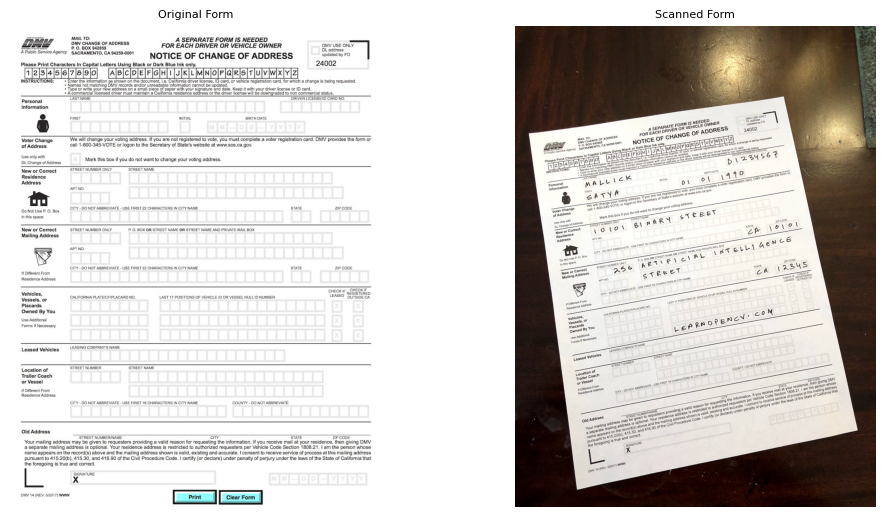

In [16]:
# Display Images
images_dict = {
    "Original Form": im1,
    "Scanned Form": im2,
}

display_images_from_dict(images_dict)

## Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

In [17]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)


# Detect ORB features using OpenCV and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.compute(im1, orb.detect(im1,None))
keypoints2, descriptors2 = orb.compute(im2, orb.detect(im2,None))

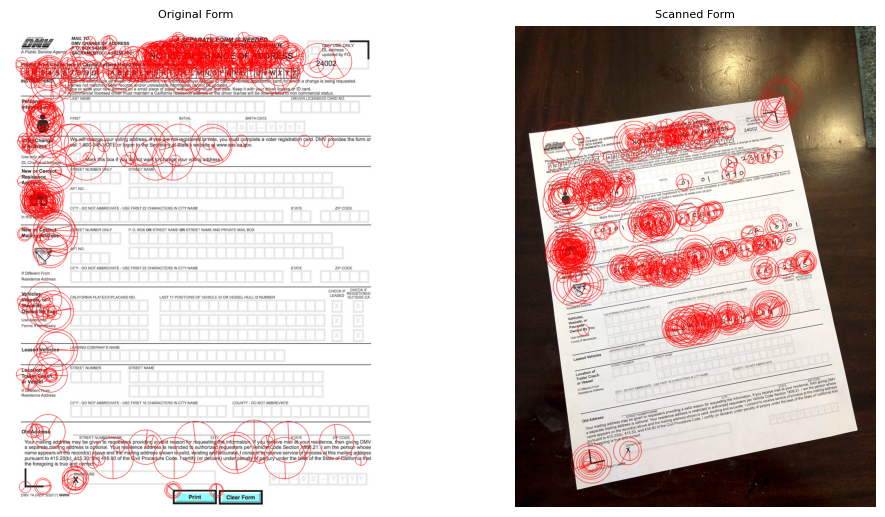

True

In [18]:
# Display
im1_display = cv2.drawKeypoints(
    im1,
    keypoints1,
    outImage=np.array([]),
    color=(255, 0, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

im2_display = cv2.drawKeypoints(
    im2,
    keypoints2,
    outImage=np.array([]),
    color=(255, 0, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

# Plot
images_dict = {
    "Original Form": im1_display,
    "Scanned Form": im2_display,
}

display_images_from_dict(images_dict)

cv2.imwrite(os.path.join(OUTPUT_FOLDER, "originalFormKP.jpg"), cv2.cvtColor(im1_display, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(OUTPUT_FOLDER, "scannedFormKP.jpg"), cv2.cvtColor(im2_display, cv2.COLOR_BGR2RGB))

## Step 3 : Match keypoints in the two image

In [19]:
# Create a DescriptorMatcher object with the BRUTEFORCE_HAMMING algorithm.
# This matcher is used to compare feature descriptors and find the best matches.
matcher = cv2.DescriptorMatcher.create("BruteForce-Hamming")

# Match the feature descriptors from two images.
# The match() function finds the best matches between descriptors1 and descriptors2.
# The resulting matches are stored in a list.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort the matches based on their distance.
# The distance represents how similar the matched descriptors are.
# Sorting in ascending order (reverse=False) means the best matches (lowest distance) come first.
matches.sort(key=lambda x: x.distance, reverse=False)

# Determine the number of good matches to keep.
# Here, we keep the top 10% of matches.
numGoodMatches = int(len(matches) * 0.1)

# Slice the sorted matches to keep only the top 'numGoodMatches'.
matches = matches[:numGoodMatches]


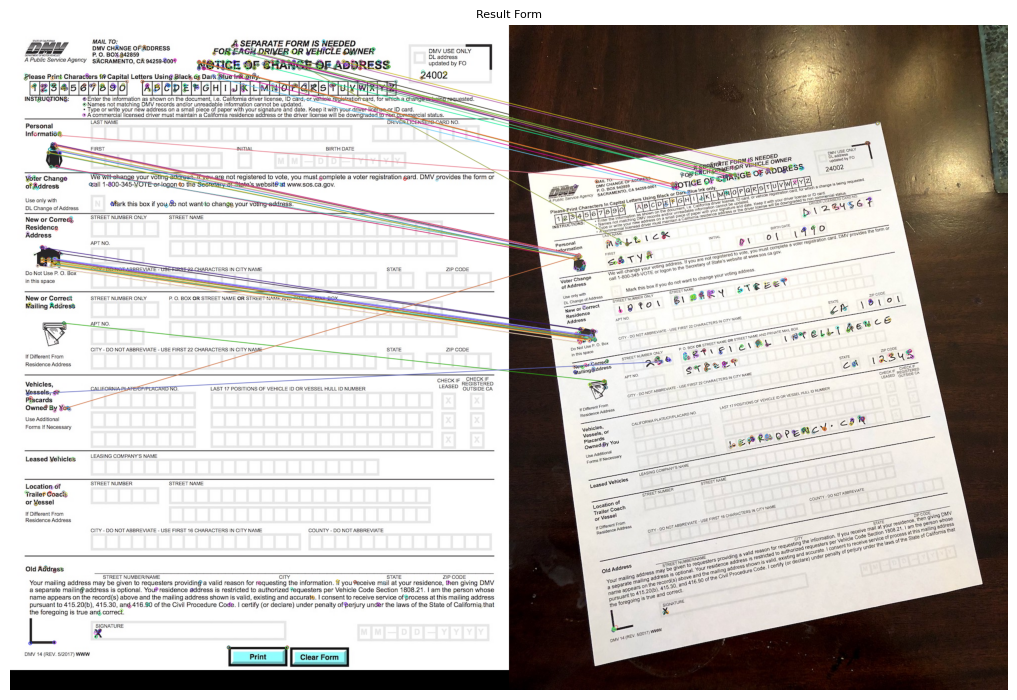

True

In [20]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

# Display im_matches
images_dict = {
    "Result Form": im_matches,
}

display_images_from_dict(images_dict,1, 10)
cv2.imwrite(os.path.join(OUTPUT_FOLDER, "matchedKPs.jpg"), cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB))


## Step 4:  Find Homography



In [21]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Step 5: Warp image

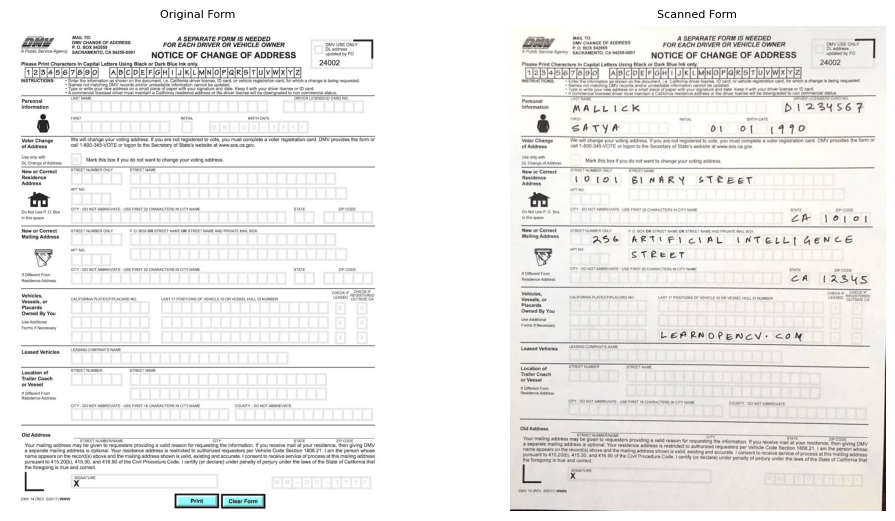

True

In [22]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
images_dict = {
    "Original Form": im1,
    "Scanned Form": im2_reg,
}

display_images_from_dict(images_dict)
cv2.imwrite(os.path.join(OUTPUT_FOLDER, "alignedImage.jpg"), cv2.cvtColor(im2_reg, cv2.COLOR_BGR2RGB))
